# Exoplanet Regression 

In [1]:
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Cleaning Data

In [2]:
pickle_in = open("exoplanet_data.pickle","rb")
exoplanet_data_full = pickle.load(pickle_in)

In [3]:
def merge(mass, mass_sini):
    if np.isnan(mass):
        return mass_sini
    return mass

#Some data has a Mass_Sini estimate for mass instead of Mass, but we can merge for all intents and purposes
exoplanet_data_full['MASS'] = exoplanet_data_full.apply(lambda row: merge(row['MASS'],row['MASS_SINI']), axis=1)

#Correct a spelling error while cleaning data
exoplanet_data_full = exoplanet_data_full.rename(index = str, columns = {'STAR_METALLICITIY':'STAR_METALLICITY'});

Let's run a quick regression with all data

In [4]:
radius_data = exoplanet_data_full.drop(columns = 'MASS_SINI')

In [5]:
yXstring = 'PLANETARY_RADIUS ~ MASS + SEMI_MAJOR_AXIS+ ORBITAL_PERIOD + ECCENTRICITY + OMEGA + TIME_PERIAPSE + INCLINATION + STAR_MASS + STAR_AGE + STAR_TEMP + STAR_RADIUS + STAR_METALLICITY'

y, X = patsy.dmatrices(yXstring, data=radius_data, return_type="dataframe")

model = sm.OLS(y, X)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       PLANETARY_RADIUS   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1.118
Date:                Thu, 18 Jul 2019   Prob (F-statistic):              0.421
Time:                        10:26:11   Log-Likelihood:                -5.2658
No. Observations:                  26   AIC:                             36.53
Df Residuals:                      13   BIC:                             52.89
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -5.4618      3.291     -1.660      0.121     -12.571       1.648
MASS                -0.0253      0.012     -2.181      0.048      -0.050      -0.000
SEMI_MAJOR_AXIS     -6.4216      6.208     -1.034      0.320     -19.833       6.990
ORBITAL_PERIOD       0.0132      0.012      1.062      0.308      -0.014       0.040
ECCENTRICITY         0.3277      0.809      0.405      0.692      -1.420       2.075
OMEGA               -0.0020      0.001     -2.035      0.063      -0.004       0.000
TIME_PERIAPSE     1.475e-08   1.99e-07      0.074      0.942   -4.15e-07    4.44e-07
INCLINATION          0.0110      0.013      0.865      0.403      -0.016       0.038
STAR_MASS           -6.0690      2.791     -2.175      0.049     -12.098      -0.040
STAR_AGE            -0.1080      0.057     -1.898      0.080      -0.231       0.015
STAR_TEMP            0.0021      0.001      2.250      0.042    8.47e-05       0.004
STAR_RADIUS          0.6582      0.524      1.255      0.232      -0.475       1.791
STAR_METALLICITY     2.9555      1.845      1.602      0.133      -1.030       6.941
==============================================================================
Omnibus:                        2.988   Durbin-Watson:                   2.745
Prob(Omnibus):                  0.224   Jarque-Bera (JB):                1.534
Skew:                          -0.285   Prob(JB):                        0.464
Kurtosis:                       4.045   Cond. No.                     2.12e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The horrible adjusted $R^2$ let's us know we have some serious cleaning to do. Many of the features will not help us.

In [6]:
#Some of the columns have few entries, so dropping columns with under 1000 entries
exoplanet_data=exoplanet_data_full.drop(columns = ['MASS_SINI','OMEGA','TIME_PERIAPSE','INCLINATION','STAR_AGE'])

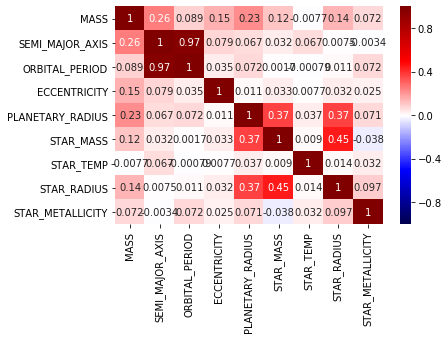

In [7]:
#Heatmap show that semi-major axis and orbital period are far too closely related, should remove one
sns.heatmap(exoplanet_data.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [8]:
#Research shows orbital period is typically directly measured, so removing semi-major-axis
exoplanet_data=exoplanet_data.drop(columns = 'SEMI_MAJOR_AXIS')

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


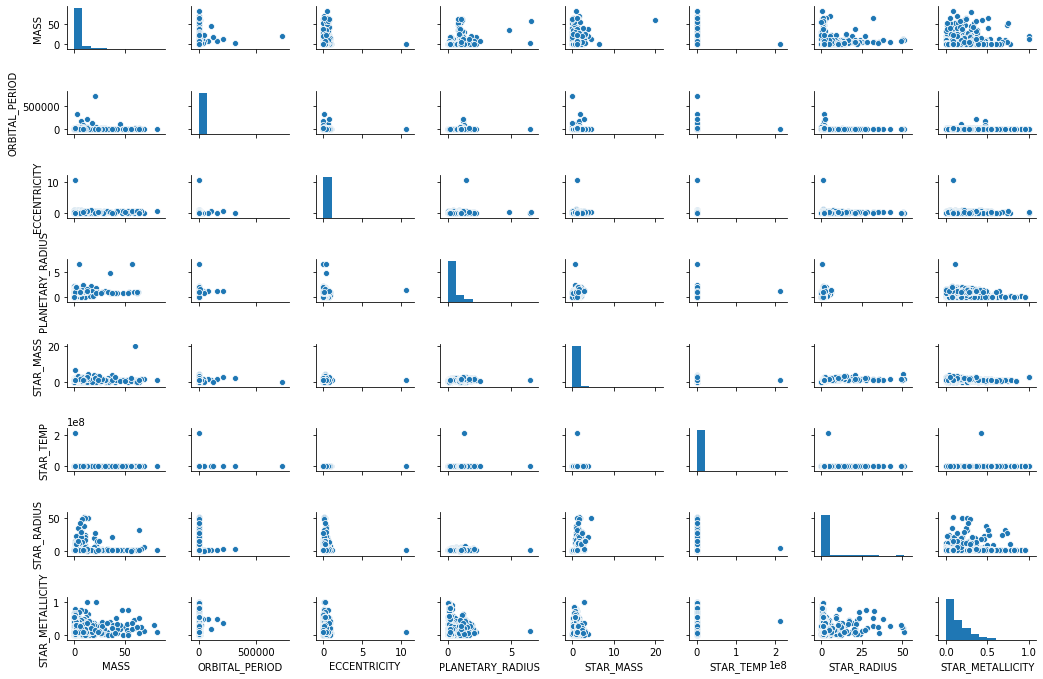

In [9]:
# Pairplot to check on data. Reveals clear outliers in multiple categories.
sns.pairplot(exoplanet_data, height=1.2, aspect=1.5);

In [10]:
yXstring = 'PLANETARY_RADIUS ~ MASS + ORBITAL_PERIOD + ECCENTRICITY + STAR_MASS + STAR_TEMP + STAR_RADIUS + STAR_METALLICITY'
y, X = patsy.dmatrices(yXstring, data=exoplanet_data, return_type="dataframe")

model = sm.OLS(y, X)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       PLANETARY_RADIUS   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     26.01
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           1.23e-30
Time:                        10:26:26   Log-Likelihood:                -339.32
No. Observations:                 538   AIC:                             694.6
Df Residuals:                     530   BIC:                             728.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3803      0.184     -2.068      0.039      -0.742      -0.019
MASS                 0.0016      0.004      0.434      0.664      -0.006       0.009
ORBITAL_PERIOD   -7.463e-06   2.25e-06     -3.315      0.001   -1.19e-05   -3.04e-06
ECCENTRICITY        -0.0064      0.041     -0.156      0.876      -0.087       0.075
STAR_MASS            0.5053      0.168      3.008      0.003       0.175       0.835
STAR_TEMP            0.0001   5.16e-05      2.739      0.006    3.99e-05       0.000
STAR_RADIUS          0.0298      0.042      0.703      0.482      -0.054       0.113
STAR_METALLICITY     0.2166      0.166      1.307      0.192      -0.109       0.542
==============================================================================
Omnibus:                      478.864   Durbin-Watson:                   1.475
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49659.257
Skew:                           3.321   Prob(JB):                         0.00
Kurtosis:                      49.596   Cond. No.                     1.08e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### The original pairplot showed a few unrealistic outliers for some columns, so we filter them out 

In [11]:
#Filtering out the outliers revealed by pairplots
filter_outlier = exoplanet_data['STAR_TEMP'] < exoplanet_data.quantile([.995])['STAR_TEMP'].iloc[0]
exoplanet_data_filtered = exoplanet_data[filter_outlier]

filter_outlier = exoplanet_data_filtered['ORBITAL_PERIOD'] < exoplanet_data_filtered.quantile([.995])['ORBITAL_PERIOD'].iloc[0]
exoplanet_data_filtered = exoplanet_data_filtered[filter_outlier]

filter_outlier = exoplanet_data_filtered['ECCENTRICITY'] < exoplanet_data_filtered.quantile([.995])['ECCENTRICITY'].iloc[0]
exoplanet_data_filtered = exoplanet_data_filtered[filter_outlier]

filter_outlier = exoplanet_data_filtered['PLANETARY_RADIUS'] < exoplanet_data_filtered.quantile([.995])['PLANETARY_RADIUS'].iloc[0]
exoplanet_data_filtered = exoplanet_data_filtered[filter_outlier]

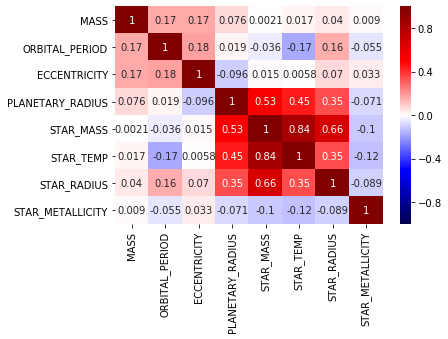

In [12]:
#Much more refined heatmap
sns.heatmap(exoplanet_data_filtered.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

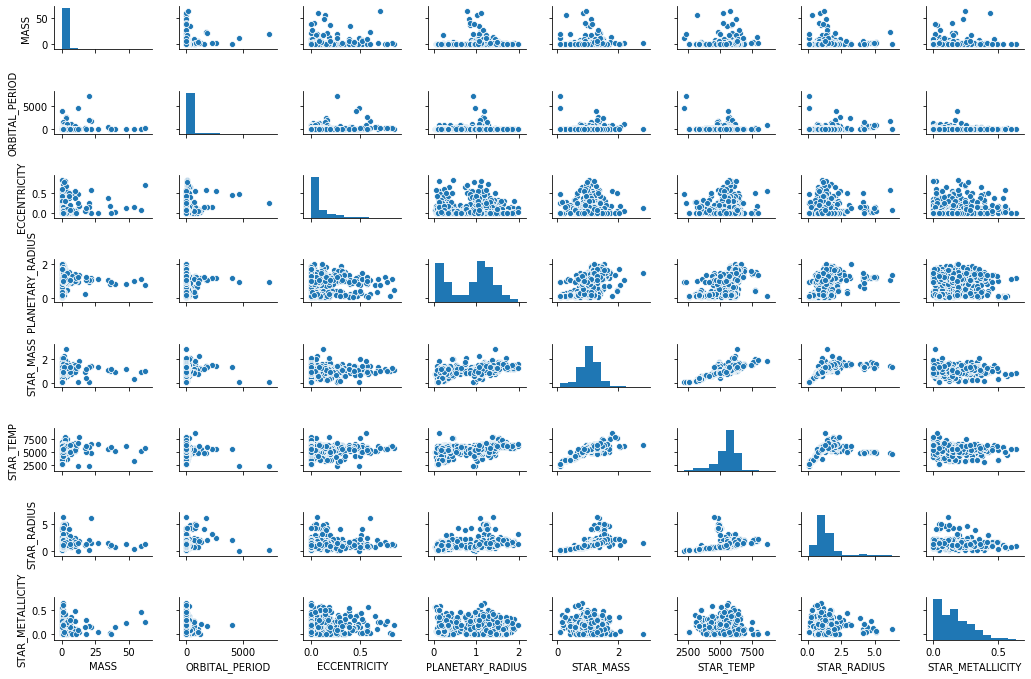

In [13]:
# Better pairplots
sns.pairplot(exoplanet_data_filtered, height=1.2, aspect=1.5);

In [14]:
yXstring = 'PLANETARY_RADIUS ~ MASS + ORBITAL_PERIOD + ECCENTRICITY + STAR_MASS + STAR_TEMP + STAR_RADIUS + STAR_METALLICITY'
y, X = patsy.dmatrices(yXstring, data=exoplanet_data_filtered, return_type="dataframe")

model = sm.OLS(y, X)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       PLANETARY_RADIUS   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     42.26
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           3.29e-47
Time:                        10:26:43   Log-Likelihood:                -229.42
No. Observations:                 531   AIC:                             474.8
Df Residuals:                     523   BIC:                             509.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.5179      0.152     -3.400      0.001      -0.817      -0.219
MASS                 0.0016      0.003      0.543      0.587      -0.004       0.007
ORBITAL_PERIOD   -4.401e-06   7.53e-05     -0.058      0.953      -0.000       0.000
ECCENTRICITY        -0.3491      0.118     -2.966      0.003      -0.580      -0.118
STAR_MASS            0.4201      0.139      3.024      0.003       0.147       0.693
STAR_TEMP            0.0002   4.28e-05      4.106      0.000    9.16e-05       0.000
STAR_RADIUS          0.0550      0.036      1.547      0.123      -0.015       0.125
STAR_METALLICITY     0.3165      0.137      2.310      0.021       0.047       0.586
==============================================================================
Omnibus:                       47.634   Durbin-Watson:                   1.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.528
Skew:                          -0.808   Prob(JB):                     1.95e-13
Kurtosis:                       3.192   Cond. No.                     6.60e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Log of Metallicity <br>
The original pairplot showed the metallicity showed a clear exponential distribution, so we investigate if taking the log of the STAR_METALLICITY will improve our correlation.

In [15]:
log_metal = exoplanet_data_filtered.copy()

In [16]:
log_metal['STAR_METALLICITY'] = log_metal['STAR_METALLICITY'].replace(float(0), np.nan);

In [17]:
log_metal = log_metal.dropna()

In [18]:
log_metal.describe()

,MASS,ORBITAL_PERIOD,ECCENTRICITY,PLANETARY_RADIUS,STAR_MASS,STAR_TEMP,STAR_RADIUS,STAR_METALLICITY
count,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000
mean,1.904799,39.873621,0.084736,1.007280,1.064615,5574.195171,1.297676,0.170614
std,5.744794,230.629788,0.138927,0.465956,0.306228,784.092626,0.747186,0.116913
min,0.001300,0.280324,0.000000,0.068900,0.080000,2560.000000,0.117000,0.003000
25%,0.220000,2.899703,0.000000,0.790000,0.912000,5282.000000,0.900000,0.070000
50%,0.680000,3.868138,0.020000,1.130000,1.077000,5700.000000,1.136000,0.150000
75%,1.401000,7.872880,0.115000,1.300000,1.239000,6050.000000,1.511000,0.250000
max,62.140000,4000.000000,0.836000,1.991000,2.820000,7930.000000,6.300000,0.640000


In [19]:
log_metal['STAR_METALLICITY'] = np.log(log_metal['STAR_METALLICITY'])

In [20]:
log_metal.describe()

,MASS,ORBITAL_PERIOD,ECCENTRICITY,PLANETARY_RADIUS,STAR_MASS,STAR_TEMP,STAR_RADIUS,STAR_METALLICITY
count,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000
mean,1.904799,39.873621,0.084736,1.007280,1.064615,5574.195171,1.297676,-2.116302
std,5.744794,230.629788,0.138927,0.465956,0.306228,784.092626,0.747186,0.979509
min,0.001300,0.280324,0.000000,0.068900,0.080000,2560.000000,0.117000,-5.809143
25%,0.220000,2.899703,0.000000,0.790000,0.912000,5282.000000,0.900000,-2.659260
50%,0.680000,3.868138,0.020000,1.130000,1.077000,5700.000000,1.136000,-1.897120
75%,1.401000,7.872880,0.115000,1.300000,1.239000,6050.000000,1.511000,-1.386294
max,62.140000,4000.000000,0.836000,1.991000,2.820000,7930.000000,6.300000,-0.446287


In [21]:
yXstring = 'PLANETARY_RADIUS ~ MASS + ORBITAL_PERIOD + ECCENTRICITY + STAR_MASS + STAR_TEMP + STAR_RADIUS + STAR_METALLICITY'
y, X = patsy.dmatrices(yXstring, data=log_metal, return_type="dataframe")

model = sm.OLS(y, X)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       PLANETARY_RADIUS   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     40.67
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           4.59e-45
Time:                        10:26:43   Log-Likelihood:                -211.16
No. Observations:                 497   AIC:                             438.3
Df Residuals:                     489   BIC:                             472.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.4751      0.152     -3.127      0.002      -0.774      -0.177
MASS                 0.0013      0.003      0.452      0.651      -0.004       0.007
ORBITAL_PERIOD   -2.473e-06   7.67e-05     -0.032      0.974      -0.000       0.000
ECCENTRICITY        -0.4106      0.123     -3.351      0.001      -0.651      -0.170
STAR_MASS            0.3621      0.139      2.607      0.009       0.089       0.635
STAR_TEMP            0.0002   4.33e-05      4.609      0.000       0.000       0.000
STAR_RADIUS          0.0592      0.035      1.674      0.095      -0.010       0.129
STAR_METALLICITY     0.0285      0.017      1.659      0.098      -0.005       0.062
==============================================================================
Omnibus:                       54.546   Durbin-Watson:                   1.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.724
Skew:                          -0.897   Prob(JB):                     7.24e-16
Kurtosis:                       3.385   Cond. No.                     6.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**No Improvement** <br> While there is some improvement here (almost negligible), feature engineering makes a much greater improvement to all major statistics ($R^2$ or Durbin-Watson, etc), and combining both does not seem to help either.

### Well that was disappointing! How about focusing by detection type? <br>
**Radial Velocity**

In [22]:
#Let's try by data type at least
radial_exoplanet_data=exoplanet_data_full.drop(columns = ['MASS_SINI','SEMI_MAJOR_AXIS','OMEGA','TIME_PERIAPSE','INCLINATION','STAR_AGE'])

In [23]:
#Radial Velocity Measurements
radial_filter = radial_exoplanet_data['DETECTION_TYPE'] == 'Radial Velocity'
radial_exoplanet_data = radial_exoplanet_data[radial_filter]

#Other filters
filter_outlier = radial_exoplanet_data['STAR_TEMP'] < radial_exoplanet_data.quantile([.995])['STAR_TEMP'].iloc[0]
radial_exoplanet_data = radial_exoplanet_data[filter_outlier]

filter_outlier = radial_exoplanet_data['ORBITAL_PERIOD'] < radial_exoplanet_data.quantile([.995])['ORBITAL_PERIOD'].iloc[0]
radial_exoplanet_data = radial_exoplanet_data[filter_outlier]

filter_outlier = radial_exoplanet_data['ECCENTRICITY'] < radial_exoplanet_data.quantile([.995])['ECCENTRICITY'].iloc[0]
radial_exoplanet_data = radial_exoplanet_data[filter_outlier]

In [24]:
yXstring = 'PLANETARY_RADIUS ~ MASS + ORBITAL_PERIOD + ECCENTRICITY + STAR_MASS + STAR_TEMP + STAR_RADIUS + STAR_METALLICITY'
y, X = patsy.dmatrices(yXstring, data=radial_exoplanet_data, return_type="dataframe")

model = sm.OLS(y, X)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       PLANETARY_RADIUS   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     1.691
Date:                Thu, 18 Jul 2019   Prob (F-statistic):              0.153
Time:                        10:26:43   Log-Likelihood:                -39.883
No. Observations:                  35   AIC:                             95.77
Df Residuals:                      27   BIC:                             108.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            8.7292      2.579      3.384      0.002       3.437      14.022
MASS                 0.0319      0.042      0.760      0.454      -0.054       0.118
ORBITAL_PERIOD      -0.0001      0.000     -0.520      0.607      -0.001       0.000
ECCENTRICITY        -0.2244      1.052     -0.213      0.833      -2.383       1.934
STAR_MASS            0.7438      1.802      0.413      0.683      -2.954       4.442
STAR_TEMP           -0.0012      0.001     -2.096      0.046      -0.002   -2.59e-05
STAR_RADIUS         -0.4969      0.344     -1.444      0.160      -1.203       0.209
STAR_METALLICITY    -2.2722      1.518     -1.497      0.146      -5.387       0.843
==============================================================================
Omnibus:                       41.345   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              191.647
Skew:                           2.460   Prob(JB):                     2.42e-42
Kurtosis:                      13.355   Cond. No.                     1.02e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The adjusted $R^2$ dropped precipitously! Oh no! <br>
Further research into the radial velocity methodof detecting exoplanets shows that this method is, by the nature of the measurement, unable to resolve the planetary radius alone. Looking at the data, very few of the radial velocity planets have an estimate for radius (since the estimate must be obtained by other means). So we can safely ignore planets found using radial velocity to predict planetary radius.

**Primary Transit**

In [25]:
transit_exoplanet_data=exoplanet_data_full.drop(columns = ['MASS_SINI','SEMI_MAJOR_AXIS','OMEGA','TIME_PERIAPSE','INCLINATION','STAR_AGE'])

In [26]:
transit_exoplanet_data = transit_exoplanet_data.dropna()

In [27]:
#Transit Data Measurements
transit_filter = transit_exoplanet_data['DETECTION_TYPE'] == 'Primary Transit'
transit_exoplanet_data = transit_exoplanet_data[transit_filter]

#Other filters

filter_outlier = transit_exoplanet_data['ORBITAL_PERIOD'] < transit_exoplanet_data.quantile([.999])['ORBITAL_PERIOD'].iloc[0]
transit_exoplanet_data = transit_exoplanet_data[filter_outlier]

filter_outlier = transit_exoplanet_data['ECCENTRICITY'] < transit_exoplanet_data.quantile([.999])['ECCENTRICITY'].iloc[0]
transit_exoplanet_data = transit_exoplanet_data[filter_outlier]

filter_outlier = transit_exoplanet_data['PLANETARY_RADIUS'] < transit_exoplanet_data.quantile([.999])['PLANETARY_RADIUS'].iloc[0]
transit_exoplanet_data = transit_exoplanet_data[filter_outlier]

filter_outlier = transit_exoplanet_data['STAR_RADIUS'] < transit_exoplanet_data.quantile([.999])['STAR_RADIUS'].iloc[0]
transit_exoplanet_data = transit_exoplanet_data[filter_outlier]

In [28]:
transit_exoplanet_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 494 entries, 52 to 4046
Data columns (total 10 columns):
NAME                494 non-null object
MASS                494 non-null float64
ORBITAL_PERIOD      494 non-null float64
ECCENTRICITY        494 non-null float64
PLANETARY_RADIUS    494 non-null float64
DETECTION_TYPE      494 non-null object
STAR_MASS           494 non-null float64
STAR_TEMP           494 non-null float64
STAR_RADIUS         494 non-null float64
STAR_METALLICITY    494 non-null float64
dtypes: float64(8), object(2)
memory usage: 42.5+ KB


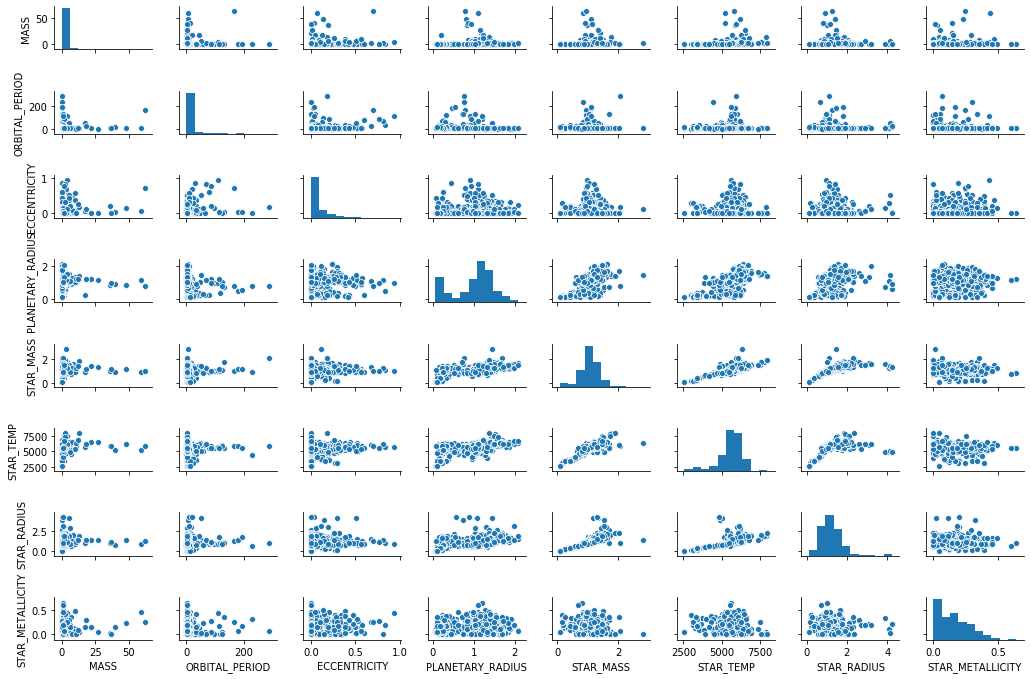

In [29]:
sns.pairplot(transit_exoplanet_data, height=1.2, aspect=1.5);

In [30]:
yXstring = 'PLANETARY_RADIUS ~ MASS + ORBITAL_PERIOD + ECCENTRICITY + STAR_MASS + STAR_RADIUS + STAR_METALLICITY'
y, X = patsy.dmatrices(yXstring, data=transit_exoplanet_data, return_type="dataframe")

model = sm.OLS(y, X)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       PLANETARY_RADIUS   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     55.15
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           7.31e-52
Time:                        10:26:56   Log-Likelihood:                -208.01
No. Observations:                 494   AIC:                             430.0
Df Residuals:                     487   BIC:                             459.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0454      0.066      0.685      0.493      -0.085       0.176
MASS                 0.0041      0.003      1.378      0.169      -0.002       0.010
ORBITAL_PERIOD      -0.0039      0.001     -6.129      0.000      -0.005      -0.003
ECCENTRICITY        -0.2095      0.119     -1.762      0.079      -0.443       0.024
STAR_MASS            0.9563      0.084     11.414      0.000       0.792       1.121
STAR_RADIUS         -0.0253      0.047     -0.537      0.591      -0.118       0.067
STAR_METALLICITY     0.2077      0.139      1.499      0.135      -0.065       0.480
==============================================================================
Omnibus:                       41.025   Durbin-Watson:                   1.253
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.331
Skew:                          -0.768   Prob(JB):                     1.94e-11
Kurtosis:                       3.188   Cond. No.                         246.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Feature Engineering

We can try some feature engineering to see if we can improve on our model

In [31]:
feature_data = transit_exoplanet_data
feature_data['STMdivPM'] = feature_data['STAR_MASS']/feature_data['MASS']

In [32]:
feature_data.head()

,NAME,MASS,ORBITAL_PERIOD,ECCENTRICITY,PLANETARY_RADIUS,DETECTION_TYPE,STAR_MASS,STAR_TEMP,STAR_RADIUS,STAR_METALLICITY,STMdivPM
52,55 Cnc e,0.02703,0.736548,0.028,0.1737,Primary Transit,1.015,5196.0,0.980,0.31,37.550869
75,BD+20 594 b,0.05130,41.685500,0.000,0.1990,Primary Transit,0.961,5766.0,0.928,0.15,18.732943
99,CoRoT-1 b,1.03000,1.508956,0.000,1.4900,Primary Transit,0.950,6298.0,1.110,0.06,0.922330
100,CoRoT-10 b,2.75000,13.240600,0.530,0.9700,Primary Transit,0.890,5075.0,0.790,0.26,0.323636
101,CoRoT-11 b,2.33000,2.994325,0.000,1.4300,Primary Transit,1.270,6343.0,1.360,0.04,0.545064


In [33]:
yXstring = 'PLANETARY_RADIUS ~ MASS + ORBITAL_PERIOD + ECCENTRICITY + STAR_MASS + STAR_RADIUS + STAR_METALLICITY + STMdivPM'
y, X = patsy.dmatrices(yXstring, data=feature_data, return_type="dataframe")

model = sm.OLS(y, X)

fit = model.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       PLANETARY_RADIUS   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     87.28
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           7.98e-82
Time:                        10:26:56   Log-Likelihood:                -134.99
No. Observations:                 494   AIC:                             286.0
Df Residuals:                     486   BIC:                             319.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2592      0.060      4.354      0.000       0.142       0.376
MASS                 0.0007      0.003      0.277      0.782      -0.004       0.006
ORBITAL_PERIOD      -0.0033      0.001     -5.885      0.000      -0.004      -0.002
ECCENTRICITY        -0.2307      0.103     -2.247      0.025      -0.432      -0.029
STAR_MASS            0.8240      0.073     11.278      0.000       0.680       0.968
STAR_RADIUS         -0.0011      0.041     -0.027      0.979      -0.081       0.079
STAR_METALLICITY    -0.0144      0.121     -0.119      0.905      -0.252       0.223
STMdivPM            -0.0064      0.000    -12.929      0.000      -0.007      -0.005
==============================================================================
Omnibus:                       29.660   Durbin-Watson:                   1.476
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.915
Skew:                          -0.283   Prob(JB):                     2.42e-16
Kurtosis:                       4.782   Cond. No.                         289.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
#Save OLS model
filename = 'OLS_model.sav'
pickle.dump(model, open(filename, 'wb'))

### Conclusion of OLS Regression 
This regression is the best one I could find through trial and error and feature engineering. Now on to validation testing.

In [35]:
final_data = feature_data

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn import pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

In [37]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 494 entries, 52 to 4046
Data columns (total 11 columns):
NAME                494 non-null object
MASS                494 non-null float64
ORBITAL_PERIOD      494 non-null float64
ECCENTRICITY        494 non-null float64
PLANETARY_RADIUS    494 non-null float64
DETECTION_TYPE      494 non-null object
STAR_MASS           494 non-null float64
STAR_TEMP           494 non-null float64
STAR_RADIUS         494 non-null float64
STAR_METALLICITY    494 non-null float64
STMdivPM            494 non-null float64
dtypes: float64(9), object(2)
memory usage: 66.3+ KB


In [38]:
validation_data = final_data.drop(columns = ['NAME','DETECTION_TYPE'])

In [39]:
def trainTest(data):
    X, y = data.drop('PLANETARY_RADIUS',axis=1), data['PLANETARY_RADIUS']
    X, X_test, y, y_test = train_test_split(X, y, test_size=.2)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25)
    #set up the 3 models we're choosing from:

    lm = LinearRegression()

    #Feature scaling for train, val, and test so that we can run our ridge model on each
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train.values)
    X_val_scaled = scaler.transform(X_val.values)
    X_test_scaled = scaler.transform(X_test.values)

    lm_reg = Ridge(alpha=1)

    #Feature transforms for train, val, and test so that we can run our poly model on each
    poly = PolynomialFeatures(degree=2) 

    X_train_poly = poly.fit_transform(X_train.values)
    X_val_poly = poly.transform(X_val.values)
    X_test_poly = poly.transform(X_test.values)

    lm_poly = LinearRegression()
    #validate

    lm.fit(X_train, y_train)
    R_list = [lm.score(X_val, y_val)]

    lm_reg.fit(X_train_scaled, y_train)
    R_list.append(lm_reg.score(X_val_scaled, y_val))

    lm_poly.fit(X_train_poly, y_train)
    R_list.append(lm_poly.score(X_val_poly, y_val))
    
    return R_list


In [40]:
R_list_total = []
for i in range(10):
    R_list_total.append(trainTest(validation_data))
    
#Average R^2 for the three models over 10 runs
R_data = pd.DataFrame(R_list_total, columns = ['Linear','Ridge','Poly2'])

In [41]:
R_data

,Linear,Ridge,Poly2
0,0.546430,0.549375,0.659031
1,0.704329,0.704094,0.149165
2,0.378496,0.380507,-4.339263
3,0.578351,0.579017,-0.606553
4,0.586332,0.586010,0.647232
5,0.585034,0.585238,0.486051
6,0.479698,0.479425,0.500535
7,0.412955,0.416938,-1.416187
8,0.459097,0.460264,-44.337716
9,-0.090715,-0.085318,-14.310296


In [42]:
Rs = R_data.mean()
Rs

Linear    0.464001
Ridge     0.465555
Poly2    -6.256800
dtype: float64

According to the validation using trainTest, it appears that the linear model and ridge perform identically, while polynomial severely overfits the data. <br>
### KFolds Cross Validation
We can run the same validation using KFolds for further confirmation.

In [43]:
from sklearn.model_selection import KFold

X, y = validation_data.drop('PLANETARY_RADIUS',axis=1), validation_data['PLANETARY_RADIUS']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2) 

X, y = np.array(X), np.array(y)

In [44]:
kf = KFold(n_splits=5, shuffle=True)
cv_lm_r2s, cv_lm_reg_r2s = [], [] 

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple regression scores:  [0.30592260884922096, 0.6341554596135321, 0.5680326572234868, 0.37692785942005136, 0.5465749828368212]
Ridge scores:  [0.3073963714781395, 0.6346474171621486, 0.5673304930258833, 0.3809725133938262, 0.5482446767240268] 

Simple mean cv r^2: 0.486 +- 0.124
Ridge mean cv r^2: 0.488 +- 0.123


### Regularization

In [45]:
X, y = validation_data.drop('PLANETARY_RADIUS',axis=1), validation_data['PLANETARY_RADIUS']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [46]:
features = ['MASS', 'ORBITAL_PERIOD', 'ECCENTRICITY','STAR_MASS', 'STAR_TEMP', 'STAR_RADIUS', 'STAR_METALLICITY','STMdivPM']

**Lasso doesn't like many of my features**

In [47]:
lasso_model = Lasso(alpha = 1)
lasso_model.fit(X_train.loc[:,features], y_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [48]:
list(zip(features, lasso_model.coef_))

[('MASS', -0.0),
 ('ORBITAL_PERIOD', -0.0016335412953082376),
 ('ECCENTRICITY', -0.0),
 ('STAR_MASS', 0.0),
 ('STAR_TEMP', 0.0003084689957915162),
 ('STAR_RADIUS', 0.0),
 ('STAR_METALLICITY', 0.0),
 ('STMdivPM', -0.004412375368325711)]

**In fact, Lasso completely flattened Star Mass and Star Radius** <br>
Planetary radius appeared to be most correlated to star mass, but after filtering our data using Transit data and eliminating outliers, it appears that star mass/radius is perhaps too highly correlated to planetary radius.

**Ridge similarly doesn't like many features**

In [49]:
ridge_model = Ridge(alpha = 1)
ridge_model.fit(X_train.loc[:,features], y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [50]:
list(zip(features, ridge_model.coef_))

[('MASS', -0.0020669332637081356),
 ('ORBITAL_PERIOD', -0.002959320865573152),
 ('ECCENTRICITY', -0.2019315451987853),
 ('STAR_MASS', 0.3218505530577706),
 ('STAR_TEMP', 0.0001683751742442091),
 ('STAR_RADIUS', 0.07833431413074558),
 ('STAR_METALLICITY', 0.06682223834526894),
 ('STMdivPM', -0.005175950487546813)]

**Standardize values then select best alpha for Lasso**

In [51]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.loc[:,features].values, y_train)
    
    val_set_pred = pipe.predict(X_val.loc[:,features].values)
    err_vec_val[i] = mean_absolute_error(y_val, val_set_pred)

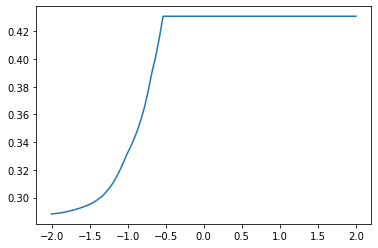

In [52]:
plt.plot(np.log10(alphalist), err_vec_val);

In [53]:
print(np.min(err_vec_val))
best_alpha = alphalist[np.argmin(err_vec_val)]
print(best_alpha)

0.2881961129539987
0.01


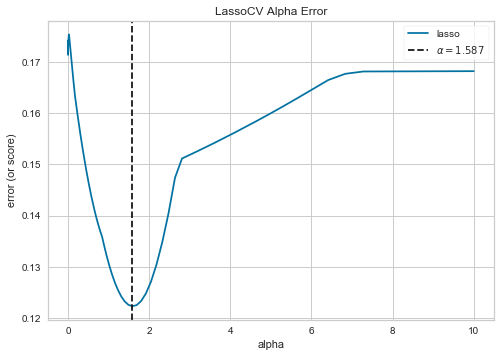

In [82]:
from yellowbrick.regressor import AlphaSelection

# Create a list of alphas to cross-validate against
alphas = np.logspace(-10, 1, 400)

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas, cv = 5)
visualizer = AlphaSelection(model)

visualizer.fit(X, y)
g = visualizer.poof()

**We find the mean absolute error against the test set, and confirm no Lasso is best for our data**

In [54]:
for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.loc[:,features].values, y_train)
    
    val_set_pred = pipe.predict(X_test.loc[:,features].values)
    err_vec_val[i] = mean_absolute_error(y_test, val_set_pred)

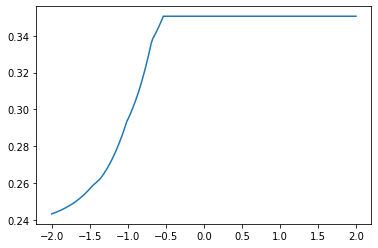

In [55]:
plt.plot(np.log10(alphalist), err_vec_val);

In [56]:
print(np.min(err_vec_val))
best_alpha = alphalist[np.argmin(err_vec_val)]
print(best_alpha)

0.24317051124349234
0.01


### Visualizing Ridge/Lasso further using yellowbrick module

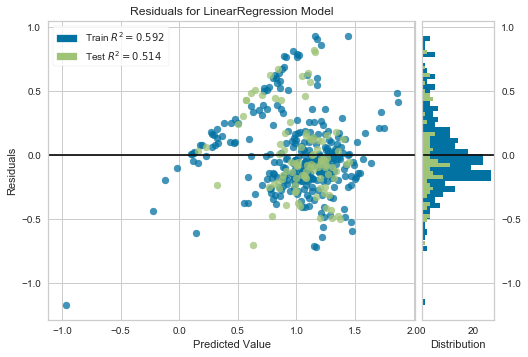

In [57]:
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
ridge = LinearRegression()
visualizer = ResidualsPlot(ridge)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

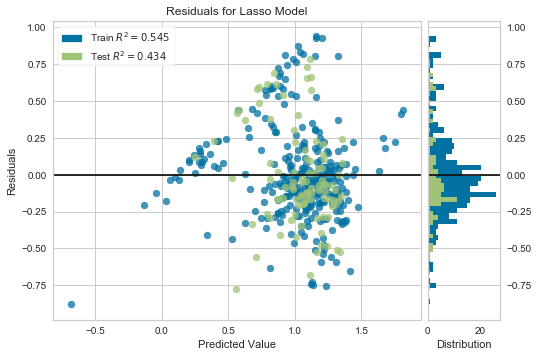

In [58]:
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
ridge = Lasso(alpha = 1)
visualizer = ResidualsPlot(ridge)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

**Residuals for the linear regression are more or less normally distributed**
This indicates Linear Regression is a good fit for the data. <br>
There is clearly an outlier in the data. I've also shown the residual plot for Ridge Model, although there is almost no difference, as shown by various other figures previously.

In [59]:
lasso_model = Lasso(alpha = 1)
lasso_model.fit(X_train.loc[:,features], y_train)
lasso_model.score(X_test,y_test)

0.43422003074592724

In [60]:
lm = LinearRegression()
linear_model = lm.fit(X_train.loc[:,features], y_train)
linear_model.score(X_test,y_test)

0.5140017162884167

## In Conclusion <br>
No improvement can be made using Ridge, Lasso, or ElasticNet to the original Linear Regression. 
However, Lasso clearly eliminated Star Mass / Radius, and research shows that the Star Radius is used to calculate planet Radius (along with the Transit Curve), and Star Mass is well known to be proportional to Star Radius. Thus, it may be prudent to stick to the Lasso model, even if it is not the best fit.

In [61]:
#Save my Linear Model
filename = 'Linear_model.sav'
pickle.dump(linear_model, open(filename, 'wb'))

In [62]:
#Save my Lasso_model
filename = 'Lasso_model.sav'
pickle.dump(lasso_model, open(filename, 'wb'))

In [63]:
loaded_linear = pickle.load(open('Linear_model.sav', 'rb'))
result = loaded_linear.score(X, y)
print(result)

0.5594301414031773


In [64]:
loaded_lasso = pickle.load(open('Lasso_model.sav', 'rb'))
result = loaded_lasso.score(X, y)
print(result)

0.504641965407893


### Just for fun search for the Goldilocks planets! <br>
Reasonable estimates put habitable planets at .25 Earth Radius - 3 Earth Radius <br>
We filter out data without planetary radius, and use our model to look for planets in this range. The planetary radius and mass were given in Jupiter units.

In [99]:
#Leave planets without radius only
all_data=exoplanet_data_full.drop(columns = ['MASS_SINI','SEMI_MAJOR_AXIS','OMEGA','TIME_PERIAPSE','INCLINATION','STAR_AGE'])
radius_filter = pd.isnull(all_data['PLANETARY_RADIUS'])
all_data = all_data[radius_filter]
all_data = all_data.drop(columns = 'PLANETARY_RADIUS')
all_data = all_data.dropna()
all_data['STMdivPM'] = all_data['STAR_MASS']/all_data['MASS']

In [100]:
#Other filters

filter_outlier = all_data['ORBITAL_PERIOD'] < all_data.quantile([.999])['ORBITAL_PERIOD'].iloc[0]
all_data = all_data[filter_outlier]

filter_outlier = all_data['ECCENTRICITY'] < all_data.quantile([.999])['ECCENTRICITY'].iloc[0]
all_data = all_data[filter_outlier]

filter_outlier = all_data['STAR_RADIUS'] < all_data.quantile([.999])['STAR_RADIUS'].iloc[0]
all_data = all_data[filter_outlier]

In [101]:
no_categorical = all_data.drop(columns = ['NAME','DETECTION_TYPE'])

In [102]:
#formatting dataframe to merge with earth radius
all_data2 = all_data.reset_index()
all_data2 = all_data2.drop(columns = 'index')

In [103]:
#Store predicted Radius values data without planetary radius
earth_radii = pd.DataFrame(loaded_lasso.predict(no_categorical) * 11.2, columns = ['EARTH_RADIUS'])

#merge this data with dataframe with names
goldilocks_data = pd.concat([all_data2, earth_radii], axis = 1)
cols = ['NAME', 'EARTH_RADIUS','MASS', 'ORBITAL_PERIOD', 'ECCENTRICITY', 'DETECTION_TYPE','STAR_MASS', 'STAR_TEMP', 'STAR_RADIUS', 'STAR_METALLICITY', 'STMdivPM']
goldilocks_data = goldilocks_data[cols]

#filter out the goldilocks zone planets!
goldilocks_data = goldilocks_data[(goldilocks_data['EARTH_RADIUS']<3) & (goldilocks_data['EARTH_RADIUS'] > 0)]

In [104]:
goldilocks_data.head(20)

,NAME,EARTH_RADIUS,MASS,ORBITAL_PERIOD,ECCENTRICITY,DETECTION_TYPE,STAR_MASS,STAR_TEMP,STAR_RADIUS,STAR_METALLICITY,STMdivPM
7,24 Sex b,2.053342,1.990000,452.80000,0.090,Radial Velocity,1.540,5098.0,4.9000,0.030,0.773869
10,38 Vir b,0.293174,4.510000,825.90000,0.030,Primary Transit,1.180,6557.0,1.4500,0.070,0.261641
31,BD+48 738 b,0.789679,0.910000,392.60000,0.200,Radial Velocity,0.740,4414.0,11.0000,0.200,0.813187
37,GJ 1132 c,2.820643,0.008310,8.92900,0.270,Radial Velocity,0.181,3270.0,0.2070,0.120,21.780987
39,GJ 15A b,2.932573,0.009530,11.44070,0.094,Radial Velocity,0.375,3567.0,0.3863,0.320,39.349423
42,GJ 273 b,2.029289,0.006900,18.64000,0.030,Radial Velocity,0.290,3382.0,0.2930,0.090,42.028986
43,GJ 273 c,0.589500,0.003800,4.72322,0.120,Radial Velocity,0.290,3382.0,0.2930,0.090,76.315789
47,GJ 3138 b,2.945861,0.013200,5.97400,0.110,Radial Velocity,0.681,3717.0,0.5000,0.300,51.590909
51,GJ 3293 c,2.181359,0.066360,122.61960,0.110,Radial Velocity,0.420,3466.0,0.4040,0.020,6.329114
52,GJ 3293 d,2.992064,0.024000,48.13450,0.120,Radial Velocity,0.420,3466.0,0.4040,0.020,17.500000


In [105]:
goldilocks_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68 entries, 7 to 508
Data columns (total 11 columns):
NAME                68 non-null object
EARTH_RADIUS        68 non-null float64
MASS                68 non-null float64
ORBITAL_PERIOD      68 non-null float64
ECCENTRICITY        68 non-null float64
DETECTION_TYPE      68 non-null object
STAR_MASS           68 non-null float64
STAR_TEMP           68 non-null float64
STAR_RADIUS         68 non-null float64
STAR_METALLICITY    68 non-null float64
STMdivPM            68 non-null float64
dtypes: float64(9), object(2)
memory usage: 6.4+ KB


**Success! 68 planets without planetary radii predicted to have habitable radii according to our Lasso model with alpha = 1** <br>

Let's see if our model at least can accurately identify which planets are in the goldilocks zone for Transit data.

In [83]:
X, y = validation_data.drop('PLANETARY_RADIUS',axis=1), validation_data['PLANETARY_RADIUS']

In [84]:
X2 = final_data.drop('PLANETARY_RADIUS', axis = 1)
#cleaning dataframe to merge with earth radius
X2 = X2.reset_index()
X2 = X2.drop(columns = 'index')

In [115]:
#Store predicted Radius values data without planetary radius
earth_radii = pd.DataFrame(loaded_lasso.predict(X) * 11.2, columns = ['EARTH_RADIUS'])

#merge this data with dataframe with names
test_goldilocks = pd.concat([X2, earth_radii], axis = 1)

cols = ['NAME', 'EARTH_RADIUS','MASS', 'ORBITAL_PERIOD', 'ECCENTRICITY', 'DETECTION_TYPE','STAR_MASS', 'STAR_TEMP', 'STAR_RADIUS', 'STAR_METALLICITY', 'STMdivPM']
test_goldilocks = test_goldilocks[cols]

In [118]:
#filter out the goldilocks zone planets!
test_goldilocks = test_goldilocks[(test_goldilocks['EARTH_RADIUS']<3) & (test_goldilocks['EARTH_RADIUS'] > 0)]
test_goldilocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 41 to 358
Data columns (total 11 columns):
NAME                13 non-null object
EARTH_RADIUS        13 non-null float64
MASS                13 non-null float64
ORBITAL_PERIOD      13 non-null float64
ECCENTRICITY        13 non-null float64
DETECTION_TYPE      13 non-null object
STAR_MASS           13 non-null float64
STAR_TEMP           13 non-null float64
STAR_RADIUS         13 non-null float64
STAR_METALLICITY    13 non-null float64
STMdivPM            13 non-null float64
dtypes: float64(9), object(2)
memory usage: 1.2+ KB


In [91]:
test_goldilocks

,NAME,EARTH_RADIUS,MASS,ORBITAL_PERIOD,ECCENTRICITY,DETECTION_TYPE,STAR_MASS,STAR_TEMP,STAR_RADIUS,STAR_METALLICITY,STMdivPM
41,GJ 1132 b,2.317031,0.005220,1.628931,0.00,Primary Transit,0.181,3270.0,0.207,0.120,34.674330
42,GJ 1214 b,2.823785,0.020325,1.580405,0.27,Primary Transit,0.150,3026.0,0.216,0.390,7.379954
48,Gj 357 b,1.505795,0.005130,3.930560,0.02,Primary Transit,0.342,3505.0,0.337,0.120,66.666667
211,K2-3 c,1.468284,0.006730,24.646582,0.04,Primary Transit,0.612,3951.0,0.553,0.300,90.936107
242,Kepler-109 b,0.322723,0.004100,6.481637,0.21,Primary Transit,1.069,5952.0,1.339,0.080,260.731707
258,Kepler-167 d,2.673890,0.006000,21.803855,0.00,Primary Transit,0.760,4796.0,0.700,0.052,126.666667
292,Kepler-445 d,2.712164,0.011000,8.152750,0.00,Primary Transit,0.180,3157.0,0.210,0.190,16.363636
320,LHS 1140 b,2.782363,0.020900,24.737120,0.29,Primary Transit,0.146,3131.0,0.186,0.240,6.985646
321,LHS 1140 c,2.243012,0.005690,3.777931,0.00,Primary Transit,0.146,3131.0,0.186,0.240,25.659051
350,TOI-270 b,1.105105,0.006000,3.360080,0.00,Primary Transit,0.400,3386.0,0.380,0.170,66.666667


In [88]:
actual_goldilocks = final_data.copy()
actual_goldilocks['EARTH_RADIUS'] = actual_goldilocks['PLANETARY_RADIUS']*11.2
actual_goldilocks = actual_goldilocks.drop('PLANETARY_RADIUS', axis = 1)
cols = ['NAME', 'EARTH_RADIUS','MASS', 'ORBITAL_PERIOD', 'ECCENTRICITY', 'DETECTION_TYPE','STAR_MASS', 'STAR_TEMP', 'STAR_RADIUS', 'STAR_METALLICITY', 'STMdivPM']
actual_goldilocks = actual_goldilocks[cols]
actual_goldilocks = actual_goldilocks[(actual_goldilocks['EARTH_RADIUS']<3) & (actual_goldilocks['EARTH_RADIUS'] > 0)]

In [120]:
actual_goldilocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75 entries, 52 to 3808
Data columns (total 11 columns):
NAME                75 non-null object
EARTH_RADIUS        75 non-null float64
MASS                75 non-null float64
ORBITAL_PERIOD      75 non-null float64
ECCENTRICITY        75 non-null float64
DETECTION_TYPE      75 non-null object
STAR_MASS           75 non-null float64
STAR_TEMP           75 non-null float64
STAR_RADIUS         75 non-null float64
STAR_METALLICITY    75 non-null float64
STMdivPM            75 non-null float64
dtypes: float64(9), object(2)
memory usage: 9.5+ KB


In [137]:
matchlist = []
for index, row in test_goldilocks.iterrows():
    if actual_goldilocks['NAME'].eq(row[0]).any():
        matchlist.append(row[0])
matchlist

['GJ 1132 b',
 'GJ 1214 b',
 'Gj 357 b',
 'K2-3 c',
 'Kepler-109 b',
 'Kepler-167 d',
 'Kepler-445 d',
 'LHS 1140 b',
 'LHS 1140 c',
 'TOI-270 b',
 'TRAPPIST-1 b',
 'TRAPPIST-1 c',
 'TRAPPIST-1 g']

In [138]:
len(matchlist)

13

### Success! Sort of <br>
Our model identified 13 planets as being in the goldilocks zone, and all were actually in the zone! However, the model only identified 13 out of 75 possible. So, no false positives at least?